# Obtención Pixel Metro

### Imports

In [1]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

### Obtener una imagen de mesa recortada

In [18]:
b,g,r = cv2.split(cv2.imread("segmentation_masks/36.png"))
img = r
img = cv2.resize(img,(320,180))
thresh = cv2.threshold(img,128,255,cv2.THRESH_BINARY)[1]
contours,hierarchy = cv2.findContours(thresh, 1, 2)
for a in range(len(contours)):
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    if w<=5 or h<=5:
        continue
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),1)

ValueError: not enough values to unpack (expected 3, got 0)

In [ ]:
im = Image.open(r"./images/10000036.jpg")

In [16]:
croped = im.crop((x*6, y*6, x*6+w*6 , y*6+h*6))

NameError: name 'im' is not defined

In [17]:
croped.save("./table", "jpeg")

NameError: name 'croped' is not defined

### Implementación

In [2]:
img = cv2.imread("./taula2.JPG")
img = cv2.resize(img,(400,60))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
#ret,blur_gray = cv2.threshold(gray,120,255,cv2.THRESH_BINARY)

In [3]:
#blur_gray = imagen - gray
low_threshold = 50
high_threshold = 125
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

In [4]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40  # minimum number of pixels making up a line
max_line_gap = 30  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(closing, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

In [5]:
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

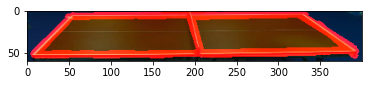

In [6]:
plt.imshow(lines_edges)

In [7]:
def getMaxLine(lines):
    """
    Encuentra la linea más larga que será la de 2.74 m de la mesa
    """
    maxline = 0
    maxvalues = []
    m = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if dist>maxline:
                maxline = dist
                maxvalues = [x1,y1,x2,y2]
    return maxvalues


def eraseDuplicates(lines, l, acc = 10):
    """
    Elimina las lineas repetidas
    """
    new_lines = []
    xl1,yl1,xl2,yl2 = l
    xm1,ym1,xm2,ym2 = l
    count = 1
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (abs(x1 - xl1) <= acc) and (abs(y1 - yl1) <= acc):
                if (abs(x2 - xl2) <= acc) and (abs(y2 - yl2) <= acc):
                    xm1 += x1
                    ym1 += y1
                    xm2 += x2
                    ym2 += y2
                    count +=1
                    continue
            new_lines.append(line)
    return (np.array(new_lines),[int(xm1/count),int(ym1/count),int(xm2/count),int(ym2/count)])

                    
def getBestCorner(lines, l, right, acc = 10):
    """
    Encuentra las lineas paralelas a la dada sin devolver repeticiones
    """
    lines,_ = eraseDuplicates(lines, l)
    xl1,yl1,xl2,yl2 = l
    ml = (yl2 - yl1)/(xl2 - xl1)
    
    best_line = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if right == True:
                if (abs(x1 - xl1) <= acc) and (abs(y1 - yl1) <= acc):
                    m = (y2 - y1)/(x2 - x1)
                    alpha = math.atan((ml - m)/(1+ml*m))* 180 / np.pi
                    if (alpha>25 and alpha<90) or (alpha < -40 and alpha > -90):
                        best_line.append([[x1,y1,x2,y2]])
            else:
                if (abs(x2 - xl2) <= acc) and (abs(y2 - yl2) <= acc):
                    m = (y2 - y1)/(x2 - x1)
                    alpha = math.atan((ml - m)/(1+ml*m))* 180 / np.pi
                    if (alpha<-20 and alpha>-90) or (alpha > 40 and alpha < 90):
                        best_line.append([[x1,y1,x2,y2]])
                    
    if best_line == []: #No ha encontrado linea buena
        return getBestCorner(lines, l, right, acc+1)
    else:
        return getMaxLine(np.array(best_line))
    
def getRectangle(img,lines):
    """
    Crea el rectangulo a partir de las lineas sacadas de la imagen
    """
    xa1,ya1,xb1,yb1 = getMaxLine(lines)
    xa2,ya2,xc1,yc1 = getBestCorner(lines,getMaxLine(lines),True)
    xd1,yd1,xb2,yb2 = getBestCorner(lines,getMaxLine(lines),False)
    y,x,_ = img.shape
    xa = int(((xa1 + xa2) / 2)*x/400)
    ya = int(((ya1 + ya2) / 2)*y/60)
    xb = int(((xb1 + xb2) / 2)*x/400)
    yb = int(((yb1 + yb2) / 2)*y/60)
    xc = int(xc1*x/400)
    yc = int(yc1*y/60)
    xd = int(xd1*x/400)
    yd = int(yd1*y/60)
    cv2.line(img,(xa,ya),(xb,yb),(255,255,0),5);
    cv2.line(img,(xa,ya),(xc,yc),(255,255,0),5);
    cv2.line(img,(xd,yd),(xb,yb),(255,255,0),5);
    cv2.line(img,(xc,yc),(xd,yd),(255,255,0),5);
    plt.imshow(img)
    return ([xa,ya],[xb,yb],[xc,yc],[xd,yd])

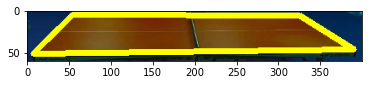

In [8]:
a,b,c,d = getRectangle(img,lines)

In [9]:
# a b = 2.74
# c d = 2.74
# a c = 1.525
# b d = 1.525

In [23]:
# Sumar a las rectas las coordenadas x0 y y0 

In [3]:
def getDist(pt,l):
    """
    Devuleve la distáncia entre un punto y una linea
    """
    x1,y1,x2,y2 = l
    px,py = pt
    m = (y2 - y1)/(x2 - x1)
    n = y1 - (x1 * m)
    dist = ((-m*px) + py - n) / math.sqrt( m**2 + 1)
    return dist

def getPixelMeterX(pt,l1,l2, horitzontal = True):
    """
    Devuelve la relación píxel metro de un punto en el eje "X"
    """
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    dl1 = math.sqrt((x1-x2)**2+(y1-y2)**2)
    dl2 = math.sqrt((a1-a2)**2+(b1-b2)**2)
    d1_2 = getDist((a1,b1),l1)
    d1_p = getDist(pt,l1)
    if horitzontal == True:
        rel = 2.74
    else:
        rel = 1.525
    pm = (dl1 - ((dl1-dl2)/d1_2)*d1_p) / rel
    return pm

def getPointSec(l1,l2):
    """
    Devuelve el punto de corte entre dos rectas, si estas son paralelas
    se asume punto en el centro y a una distancia "infinita"
    """
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    m1 = (y2 - y1)/(x2 - x1)
    m2 = (b2 - b1)/(a2 - a1)
    n1 = y1 - (x1 * m1)
    n2 = b1 - (a1 * m2)
    if m1 == m2:
        return ((((1-n1)/m1)+((1-n2)/m2))/2,999999999)
    px = (n2 - n1) / (m1 - m2)
    py = m1*px + n1
    return (px,py)

def getRectaPerp(pt,l):
    """
    Devuelve la recta perpendicular a otra que pasa por un punto
    """
    x1,y1,x2,y2 = l
    px,py = pt
    ml = (y2 - y1)/(x2 - x1)
    m = 1 / ml
    n = py - (px * m)
    lperp = [px,py,px+50,(m*(px+50))+n]
    return lperp

def getAngleRect(l1,l2):
    """
    Devuelve el angulo formado por dos rectas
    """
    x1,y1,x2,y2 = l1
    a1,b1,a2,b2 = l2
    m1 = (y2 - y1)/(x2 - x1)
    m2 = (b2 - b1)/(a2 - a1)
    alpha = math.atan((m1 - m2)/(1+m1*m2))* 180 / np.pi
    return abs(alpha)

def getPixelMeterY(pt, l1, l2, l3, l4, horitzontal = False, paralel = True):
    """
    Devuelve la relación píxel metro de un punto en el eje "Y" y el punto focal
    pt: punto de movimiento
    l1: recta horizontal de mesa
    l2: recta horizontal superior mesa
    l3: recta lateral de mesa
    l4: recta otro lateral de mesa
    """
    pa,pb = getPointSec(l3,l4)
    px,py = pt
    lp = [px,py,pa,pb]
    beta = getAngleRect(l3,lp)
    
    if paralel == True:
        lperp = getRectaPerp((pa,pb),l1)
        alpha = getAngleRect(l3,lperp)
        dist = getDist((l2[0],l2[1]),l1)
    else:
        alpha = getAngleRect(l3,l4)
        dist = math.sqrt((l4[0]-l4[2])**2+(l4[1]+l4[3])**2)
    
    x1,y1,x2,y2 = l3
    length = math.sqrt((x1-x2)**2+(y1-y2)**2)
    
    if horitzontal == True:
        rel = 2.74
    else:
        rel = 1.525
    
    pm = ((((beta+alpha)/alpha)*(length-dist))+dist) / rel
    return (pm, (pa,pb))


def getMeters(p1,p2,l1,l2,l3,l4):
    """
    Devuelve los metros recorridos en nuevo x y nuevo y
    p1: punto de partida
    p2: punto final
    l1: recta horizontal de mesa
    l2: recta horizontal superior mesa
    l3: recta lateral de mesa
    l4: recta otro lateral de mesa
    """
    # Det paralelismo entre l1 y l2
    paralel = True
    if paralel == True:
        pmx = getPixelMeterX(p1,l1,l2)
        pmy,pf = getPixelMeterY(p2,l1,l2,l3,l4)
    else:
        pmx,pfx = getPixelMeterY(p1,l3,l4,l1,l2,horitzontal=True,paralel=False)
        pmy,pf = getPixelMeterY(p2,l1,l2,l3,l4,paralel=False)
    
    x1,y1,x2,y2 = l1
    m = (y2 - y1)/(x2 - x1)
    n = p1y - (p1x * m)
    
    p1x,p1y = p1
    if paralel == True:
        lp1 = [p1x,p1y,p1x+50,(m*(p1x+50))+n]
    else:
        lp1 = [pfx[0],pfx[1],p1x,p1y]
    
    p2x,p2y = p2
    # lp2 = [p2x,p2y,p2x+50,(m*(p2x+50))+n]
    
    p3 = getPointSec(lp1,[pf[0],pf[1],p2x,p2y])
    # p4 = getPointSec(lp2,[pf[0],pf[1],p1x,p1y])
    # De p1 a p3 dist. horizontal = De p4 a p2 dist. horizontal
    # De p1 a p4 dist. vertical = De p3 a p2 dist. vertical
    
    p3x,p3y = p3
    distX = math.sqrt((p1x-p3x)**2+(p1y-p3y)**2) # En píxeles
    distY = math.sqrt((p3x-p2x)**2+(p3y-p2y)**2)
    
    distMX = distX / pmx
    distMY = distY / pmy
    
    moved = math.sqrt(distMX**2 + distMY**2)
    
    return moved

In [12]:
getDist((2,-1),[1,-0.75,3,-2.25])

0.4

In [13]:
getAngleRect([0,1,2,-1],[1,0,2,3])

63.43494882292201

In [22]:
getPointSec([0,1,1,2],[0,2,1,3])

(-0.5, 999999999)